<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/DCGAN_with_load_and_save_model_ver4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
    plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

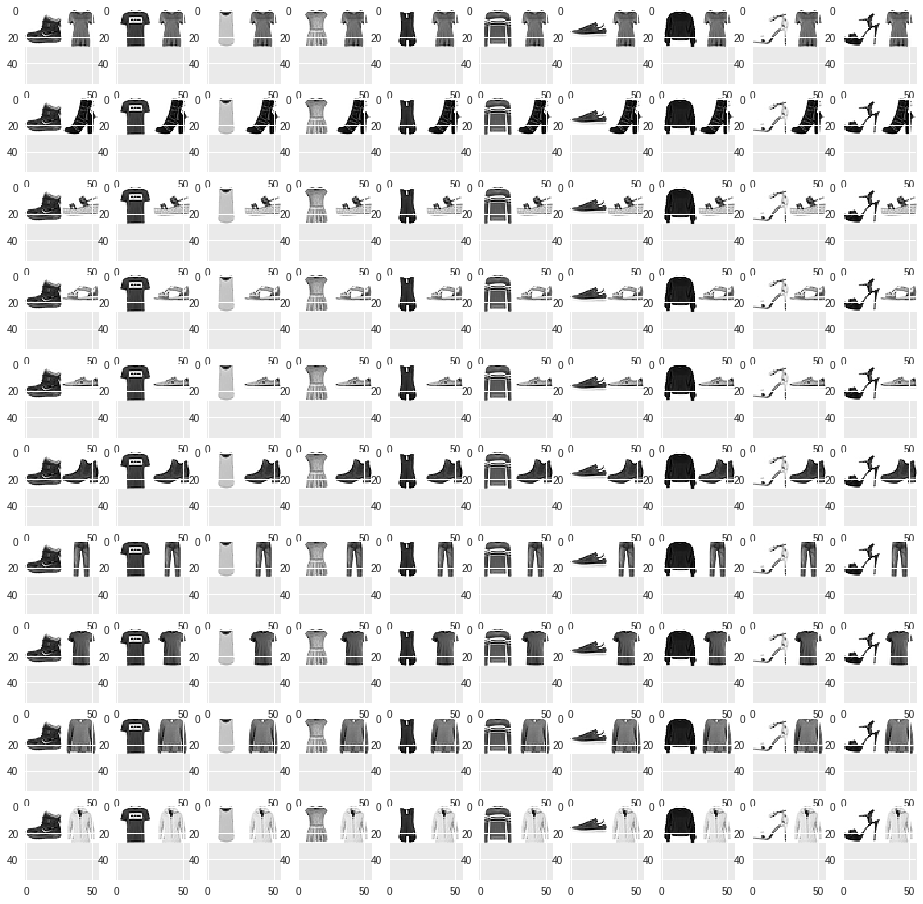

(60000, 28, 28)
(10000, 56, 56)


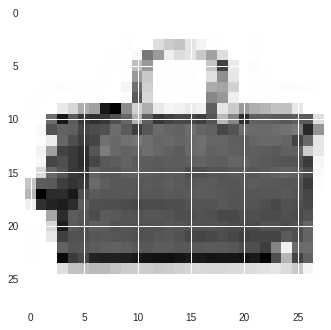

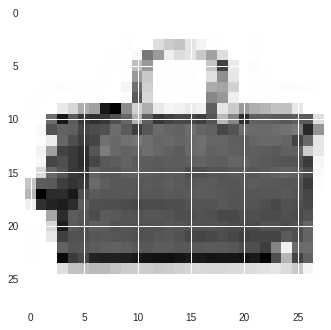

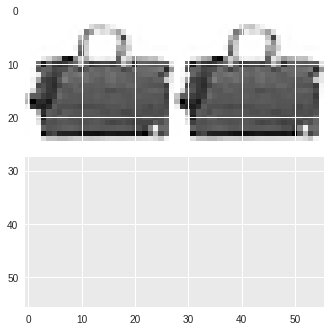

In [4]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0]/4
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=1, batch_size=32, save_interval=1)
    
    
    generator.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')
    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/468 [D loss: 0.836193, acc.: 50.00%] [G loss: 0.577333]


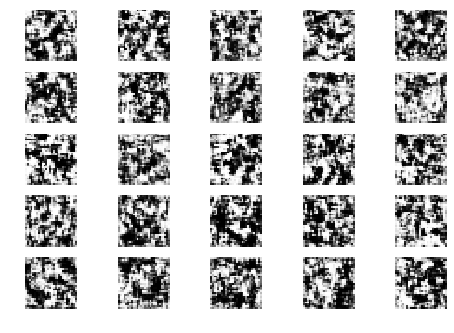

Epoch 0 Batch 1/468 [D loss: 0.798727, acc.: 53.12%] [G loss: 0.541068]
Epoch 0 Batch 2/468 [D loss: 0.585681, acc.: 68.75%] [G loss: 0.926069]
Epoch 0 Batch 3/468 [D loss: 0.502369, acc.: 78.12%] [G loss: 1.094941]
Epoch 0 Batch 4/468 [D loss: 0.530528, acc.: 75.00%] [G loss: 1.120502]
Epoch 0 Batch 5/468 [D loss: 0.400961, acc.: 87.50%] [G loss: 1.152159]
Epoch 0 Batch 6/468 [D loss: 0.292894, acc.: 93.75%] [G loss: 1.254596]
Epoch 0 Batch 7/468 [D loss: 0.417111, acc.: 81.25%] [G loss: 1.165680]
Epoch 0 Batch 8/468 [D loss: 0.316470, acc.: 84.38%] [G loss: 1.357098]
Epoch 0 Batch 9/468 [D loss: 0.343913, acc.: 87.50%] [G loss: 1.344697]
Epoch 0 Batch 10/468 [D loss: 0.302710, acc.: 93.75%] [G loss: 1.454538]
Epoch 0 Batch 11/468 [D loss: 0.321755, acc.: 90.62%] [G loss: 1.382915]
Epoch 0 Batch 12/468 [D loss: 0.391573, acc.: 81.25%] [G loss: 1.389205]
Epoch 0 Batch 13/468 [D loss: 0.327023, acc.: 90.62%] [G loss: 1.542515]
Epoch 0 Batch 14/468 [D loss: 0.360244, acc.: 84.38%] [G los

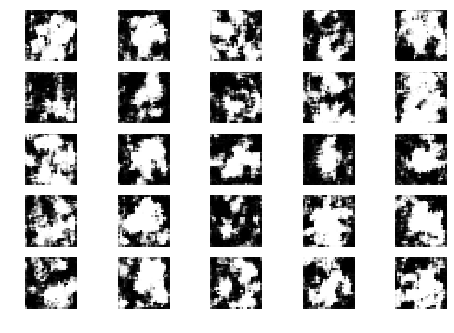

Epoch 0 Batch 51/468 [D loss: 0.813442, acc.: 62.50%] [G loss: 1.506834]
Epoch 0 Batch 52/468 [D loss: 0.331107, acc.: 81.25%] [G loss: 2.313935]
Epoch 0 Batch 53/468 [D loss: 0.206397, acc.: 90.62%] [G loss: 2.998869]
Epoch 0 Batch 54/468 [D loss: 0.353362, acc.: 75.00%] [G loss: 2.091599]
Epoch 0 Batch 55/468 [D loss: 0.262195, acc.: 93.75%] [G loss: 1.672888]
Epoch 0 Batch 56/468 [D loss: 0.314314, acc.: 90.62%] [G loss: 1.984743]
Epoch 0 Batch 57/468 [D loss: 0.370973, acc.: 75.00%] [G loss: 1.808954]
Epoch 0 Batch 58/468 [D loss: 0.202116, acc.: 100.00%] [G loss: 1.977527]
Epoch 0 Batch 59/468 [D loss: 0.333615, acc.: 93.75%] [G loss: 2.591073]
Epoch 0 Batch 60/468 [D loss: 0.111247, acc.: 100.00%] [G loss: 2.481028]
Epoch 0 Batch 61/468 [D loss: 0.066077, acc.: 100.00%] [G loss: 2.502832]
Epoch 0 Batch 62/468 [D loss: 0.356282, acc.: 90.62%] [G loss: 2.265909]
Epoch 0 Batch 63/468 [D loss: 0.129968, acc.: 100.00%] [G loss: 2.150822]
Epoch 0 Batch 64/468 [D loss: 0.080904, acc.: 1

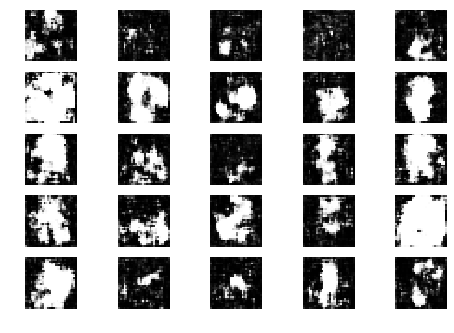

Epoch 0 Batch 101/468 [D loss: 0.428008, acc.: 75.00%] [G loss: 2.138413]
Epoch 0 Batch 102/468 [D loss: 0.188873, acc.: 90.62%] [G loss: 2.391284]
Epoch 0 Batch 103/468 [D loss: 0.646413, acc.: 59.38%] [G loss: 1.424790]
Epoch 0 Batch 104/468 [D loss: 0.962605, acc.: 53.12%] [G loss: 2.006348]
Epoch 0 Batch 105/468 [D loss: 0.284012, acc.: 93.75%] [G loss: 2.617928]
Epoch 0 Batch 106/468 [D loss: 0.749256, acc.: 62.50%] [G loss: 2.155809]
Epoch 0 Batch 107/468 [D loss: 0.422733, acc.: 81.25%] [G loss: 2.309248]
Epoch 0 Batch 108/468 [D loss: 0.486928, acc.: 84.38%] [G loss: 2.308867]
Epoch 0 Batch 109/468 [D loss: 0.397621, acc.: 78.12%] [G loss: 2.034300]
Epoch 0 Batch 110/468 [D loss: 0.526992, acc.: 75.00%] [G loss: 2.335058]
Epoch 0 Batch 111/468 [D loss: 0.283690, acc.: 81.25%] [G loss: 2.129540]
Epoch 0 Batch 112/468 [D loss: 0.288132, acc.: 90.62%] [G loss: 2.102788]
Epoch 0 Batch 113/468 [D loss: 0.539721, acc.: 68.75%] [G loss: 1.731668]
Epoch 0 Batch 114/468 [D loss: 0.52857

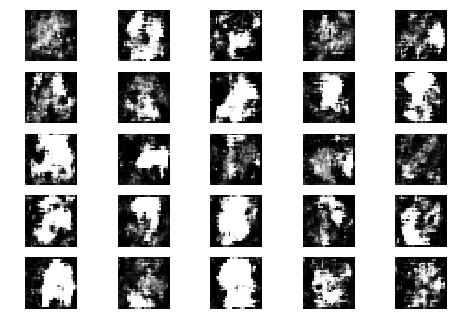

Epoch 0 Batch 151/468 [D loss: 0.322053, acc.: 84.38%] [G loss: 2.321254]
Epoch 0 Batch 152/468 [D loss: 0.639777, acc.: 75.00%] [G loss: 2.493657]
Epoch 0 Batch 153/468 [D loss: 0.860089, acc.: 59.38%] [G loss: 1.941533]
Epoch 0 Batch 154/468 [D loss: 0.487342, acc.: 71.88%] [G loss: 1.788533]
Epoch 0 Batch 155/468 [D loss: 0.297852, acc.: 90.62%] [G loss: 2.619193]
Epoch 0 Batch 156/468 [D loss: 0.334105, acc.: 87.50%] [G loss: 1.565881]
Epoch 0 Batch 157/468 [D loss: 1.034132, acc.: 40.62%] [G loss: 1.796372]
Epoch 0 Batch 158/468 [D loss: 0.376211, acc.: 84.38%] [G loss: 2.817633]
Epoch 0 Batch 159/468 [D loss: 0.406147, acc.: 81.25%] [G loss: 1.492901]
Epoch 0 Batch 160/468 [D loss: 0.614022, acc.: 62.50%] [G loss: 2.384924]
Epoch 0 Batch 161/468 [D loss: 0.436688, acc.: 78.12%] [G loss: 2.230033]
Epoch 0 Batch 162/468 [D loss: 0.454400, acc.: 84.38%] [G loss: 1.844171]
Epoch 0 Batch 163/468 [D loss: 0.655579, acc.: 62.50%] [G loss: 1.484939]
Epoch 0 Batch 164/468 [D loss: 0.67065

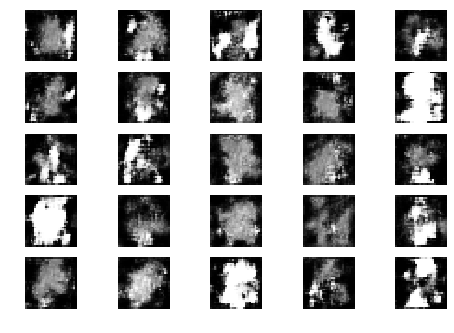

Epoch 0 Batch 201/468 [D loss: 0.767779, acc.: 53.12%] [G loss: 1.427411]
Epoch 0 Batch 202/468 [D loss: 0.504544, acc.: 71.88%] [G loss: 1.740948]
Epoch 0 Batch 203/468 [D loss: 0.821635, acc.: 56.25%] [G loss: 1.565880]
Epoch 0 Batch 204/468 [D loss: 0.497337, acc.: 78.12%] [G loss: 1.234527]
Epoch 0 Batch 205/468 [D loss: 0.671485, acc.: 71.88%] [G loss: 1.520879]
Epoch 0 Batch 206/468 [D loss: 0.370700, acc.: 84.38%] [G loss: 1.226122]
Epoch 0 Batch 207/468 [D loss: 0.609159, acc.: 71.88%] [G loss: 1.372982]
Epoch 0 Batch 208/468 [D loss: 0.608092, acc.: 75.00%] [G loss: 1.821359]
Epoch 0 Batch 209/468 [D loss: 0.684010, acc.: 68.75%] [G loss: 1.174029]
Epoch 0 Batch 210/468 [D loss: 0.551963, acc.: 78.12%] [G loss: 1.768634]
Epoch 0 Batch 211/468 [D loss: 0.579162, acc.: 68.75%] [G loss: 1.769610]
Epoch 0 Batch 212/468 [D loss: 0.654332, acc.: 65.62%] [G loss: 1.562101]
Epoch 0 Batch 213/468 [D loss: 0.431318, acc.: 84.38%] [G loss: 2.042375]
Epoch 0 Batch 214/468 [D loss: 0.46777

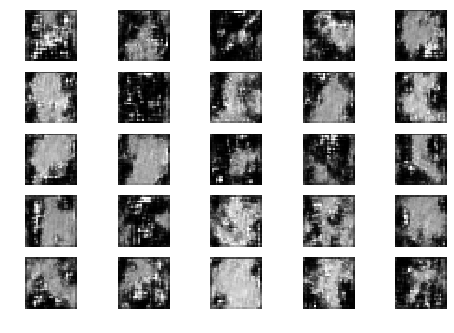

Epoch 0 Batch 251/468 [D loss: 0.926849, acc.: 53.12%] [G loss: 1.664444]
Epoch 0 Batch 252/468 [D loss: 0.722611, acc.: 59.38%] [G loss: 1.465931]
Epoch 0 Batch 253/468 [D loss: 0.685292, acc.: 59.38%] [G loss: 0.833738]
Epoch 0 Batch 254/468 [D loss: 0.901443, acc.: 56.25%] [G loss: 1.329416]
Epoch 0 Batch 255/468 [D loss: 0.661036, acc.: 71.88%] [G loss: 1.321672]
Epoch 0 Batch 256/468 [D loss: 0.720351, acc.: 65.62%] [G loss: 1.510465]
Epoch 0 Batch 257/468 [D loss: 0.721322, acc.: 68.75%] [G loss: 1.502288]
Epoch 0 Batch 258/468 [D loss: 0.666127, acc.: 68.75%] [G loss: 1.833767]
Epoch 0 Batch 259/468 [D loss: 0.852425, acc.: 56.25%] [G loss: 1.486414]
Epoch 0 Batch 260/468 [D loss: 0.557461, acc.: 71.88%] [G loss: 1.483478]
Epoch 0 Batch 261/468 [D loss: 0.392423, acc.: 78.12%] [G loss: 1.460169]
Epoch 0 Batch 262/468 [D loss: 0.808570, acc.: 62.50%] [G loss: 1.502125]
Epoch 0 Batch 263/468 [D loss: 0.609220, acc.: 65.62%] [G loss: 1.589452]
Epoch 0 Batch 264/468 [D loss: 0.64462

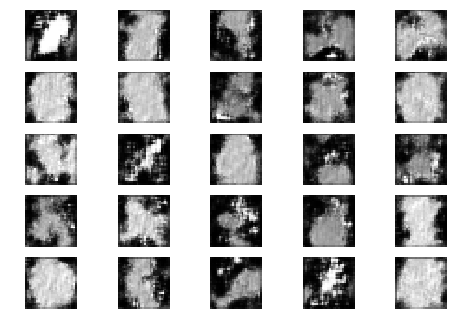

Epoch 0 Batch 301/468 [D loss: 0.514828, acc.: 68.75%] [G loss: 2.254721]
Epoch 0 Batch 302/468 [D loss: 0.450455, acc.: 78.12%] [G loss: 1.998640]
Epoch 0 Batch 303/468 [D loss: 0.699604, acc.: 62.50%] [G loss: 1.572101]
Epoch 0 Batch 304/468 [D loss: 0.727125, acc.: 68.75%] [G loss: 1.357892]
Epoch 0 Batch 305/468 [D loss: 0.420239, acc.: 78.12%] [G loss: 1.493207]
Epoch 0 Batch 306/468 [D loss: 0.473266, acc.: 75.00%] [G loss: 1.368732]
Epoch 0 Batch 307/468 [D loss: 0.506758, acc.: 71.88%] [G loss: 1.158743]
Epoch 0 Batch 308/468 [D loss: 0.648672, acc.: 59.38%] [G loss: 1.470273]
Epoch 0 Batch 309/468 [D loss: 0.675067, acc.: 59.38%] [G loss: 1.410571]
Epoch 0 Batch 310/468 [D loss: 0.587330, acc.: 71.88%] [G loss: 1.417752]
Epoch 0 Batch 311/468 [D loss: 0.551834, acc.: 78.12%] [G loss: 1.776575]
Epoch 0 Batch 312/468 [D loss: 0.786884, acc.: 62.50%] [G loss: 1.386542]
Epoch 0 Batch 313/468 [D loss: 0.431850, acc.: 81.25%] [G loss: 1.220397]
Epoch 0 Batch 314/468 [D loss: 0.85943

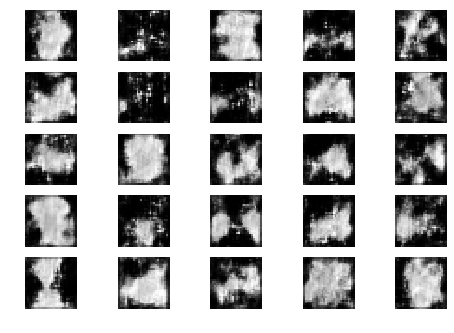

Epoch 0 Batch 351/468 [D loss: 0.678728, acc.: 68.75%] [G loss: 1.174816]
Epoch 0 Batch 352/468 [D loss: 0.777408, acc.: 62.50%] [G loss: 1.654785]
Epoch 0 Batch 353/468 [D loss: 0.616009, acc.: 65.62%] [G loss: 1.340903]
Epoch 0 Batch 354/468 [D loss: 0.458887, acc.: 81.25%] [G loss: 1.622778]
Epoch 0 Batch 355/468 [D loss: 0.617813, acc.: 65.62%] [G loss: 1.731110]
Epoch 0 Batch 356/468 [D loss: 0.656977, acc.: 62.50%] [G loss: 1.379978]
Epoch 0 Batch 357/468 [D loss: 0.626089, acc.: 56.25%] [G loss: 1.308836]
Epoch 0 Batch 358/468 [D loss: 0.640517, acc.: 68.75%] [G loss: 1.355428]
Epoch 0 Batch 359/468 [D loss: 0.492411, acc.: 78.12%] [G loss: 1.435875]
Epoch 0 Batch 360/468 [D loss: 0.682521, acc.: 68.75%] [G loss: 1.468298]
Epoch 0 Batch 361/468 [D loss: 0.529038, acc.: 71.88%] [G loss: 1.669724]
Epoch 0 Batch 362/468 [D loss: 0.532263, acc.: 68.75%] [G loss: 1.495083]
Epoch 0 Batch 363/468 [D loss: 0.502396, acc.: 75.00%] [G loss: 1.208792]
Epoch 0 Batch 364/468 [D loss: 0.43568

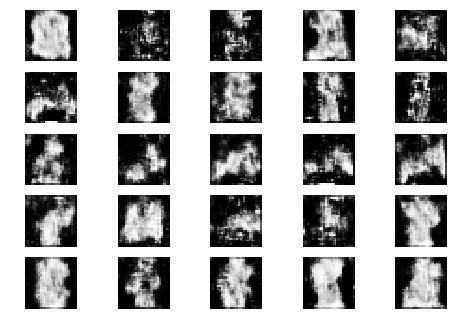

Epoch 0 Batch 401/468 [D loss: 0.633475, acc.: 68.75%] [G loss: 1.456070]
Epoch 0 Batch 402/468 [D loss: 0.748052, acc.: 68.75%] [G loss: 1.429514]
Epoch 0 Batch 403/468 [D loss: 0.816438, acc.: 46.88%] [G loss: 1.444056]
Epoch 0 Batch 404/468 [D loss: 0.484311, acc.: 75.00%] [G loss: 1.503900]
Epoch 0 Batch 405/468 [D loss: 0.621109, acc.: 71.88%] [G loss: 1.145140]
Epoch 0 Batch 406/468 [D loss: 0.556226, acc.: 62.50%] [G loss: 1.441874]
Epoch 0 Batch 407/468 [D loss: 0.636940, acc.: 71.88%] [G loss: 1.643972]
Epoch 0 Batch 408/468 [D loss: 0.530531, acc.: 71.88%] [G loss: 1.763412]
Epoch 0 Batch 409/468 [D loss: 0.594305, acc.: 75.00%] [G loss: 2.059522]
Epoch 0 Batch 410/468 [D loss: 0.564077, acc.: 75.00%] [G loss: 2.187040]
Epoch 0 Batch 411/468 [D loss: 0.640253, acc.: 59.38%] [G loss: 1.460900]
Epoch 0 Batch 412/468 [D loss: 0.775416, acc.: 59.38%] [G loss: 1.161009]
Epoch 0 Batch 413/468 [D loss: 0.548037, acc.: 65.62%] [G loss: 1.187847]
Epoch 0 Batch 414/468 [D loss: 0.62534

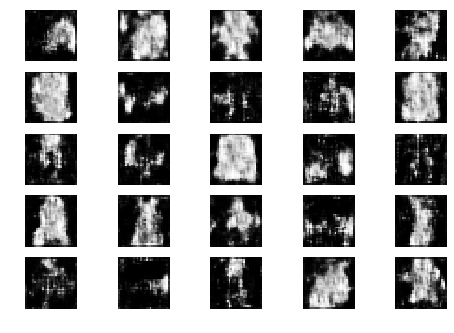

Epoch 0 Batch 451/468 [D loss: 0.586016, acc.: 68.75%] [G loss: 1.494846]
Epoch 0 Batch 452/468 [D loss: 0.777843, acc.: 56.25%] [G loss: 1.095637]
Epoch 0 Batch 453/468 [D loss: 0.722255, acc.: 53.12%] [G loss: 1.531081]
Epoch 0 Batch 454/468 [D loss: 0.598799, acc.: 68.75%] [G loss: 1.342535]
Epoch 0 Batch 455/468 [D loss: 0.844308, acc.: 50.00%] [G loss: 1.475831]
Epoch 0 Batch 456/468 [D loss: 0.683590, acc.: 65.62%] [G loss: 0.915061]
Epoch 0 Batch 457/468 [D loss: 0.538489, acc.: 65.62%] [G loss: 1.096234]
Epoch 0 Batch 458/468 [D loss: 0.601073, acc.: 68.75%] [G loss: 1.085916]
Epoch 0 Batch 459/468 [D loss: 0.482539, acc.: 71.88%] [G loss: 1.345668]
Epoch 0 Batch 460/468 [D loss: 0.461492, acc.: 75.00%] [G loss: 1.498282]
Epoch 0 Batch 461/468 [D loss: 0.505921, acc.: 68.75%] [G loss: 1.324154]
Epoch 0 Batch 462/468 [D loss: 0.684218, acc.: 53.12%] [G loss: 1.295933]
Epoch 0 Batch 463/468 [D loss: 0.824226, acc.: 53.12%] [G loss: 1.202482]
Epoch 0 Batch 464/468 [D loss: 0.56589

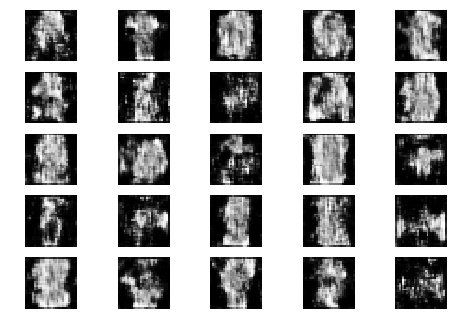

Epoch 1 Batch 1/468 [D loss: 0.788312, acc.: 59.38%] [G loss: 1.358061]
Epoch 1 Batch 2/468 [D loss: 0.738352, acc.: 56.25%] [G loss: 1.494069]
Epoch 1 Batch 3/468 [D loss: 0.613652, acc.: 71.88%] [G loss: 1.384337]
Epoch 1 Batch 4/468 [D loss: 0.568899, acc.: 71.88%] [G loss: 1.656530]
Epoch 1 Batch 5/468 [D loss: 0.665079, acc.: 68.75%] [G loss: 1.362074]
Epoch 1 Batch 6/468 [D loss: 0.482604, acc.: 84.38%] [G loss: 1.583118]
Epoch 1 Batch 7/468 [D loss: 0.628353, acc.: 65.62%] [G loss: 1.913010]
Epoch 1 Batch 8/468 [D loss: 0.604355, acc.: 75.00%] [G loss: 1.596033]
Epoch 1 Batch 9/468 [D loss: 0.499926, acc.: 78.12%] [G loss: 1.245478]
Epoch 1 Batch 10/468 [D loss: 0.665362, acc.: 62.50%] [G loss: 1.337408]
Epoch 1 Batch 11/468 [D loss: 0.557148, acc.: 62.50%] [G loss: 1.690322]
Epoch 1 Batch 12/468 [D loss: 0.429835, acc.: 75.00%] [G loss: 1.452847]
Epoch 1 Batch 13/468 [D loss: 0.408169, acc.: 81.25%] [G loss: 1.972863]
Epoch 1 Batch 14/468 [D loss: 0.720196, acc.: 56.25%] [G los

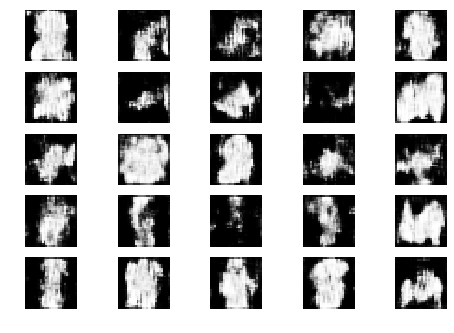

Epoch 1 Batch 51/468 [D loss: 0.343636, acc.: 87.50%] [G loss: 1.684504]
Epoch 1 Batch 52/468 [D loss: 0.539487, acc.: 68.75%] [G loss: 1.509412]
Epoch 1 Batch 53/468 [D loss: 0.639257, acc.: 65.62%] [G loss: 1.263945]
Epoch 1 Batch 54/468 [D loss: 0.492705, acc.: 75.00%] [G loss: 1.385669]
Epoch 1 Batch 55/468 [D loss: 0.483072, acc.: 75.00%] [G loss: 1.453835]
Epoch 1 Batch 56/468 [D loss: 0.652206, acc.: 59.38%] [G loss: 1.384782]
Epoch 1 Batch 57/468 [D loss: 0.616845, acc.: 71.88%] [G loss: 1.650110]
Epoch 1 Batch 58/468 [D loss: 0.490622, acc.: 71.88%] [G loss: 1.955943]
Epoch 1 Batch 59/468 [D loss: 0.294869, acc.: 93.75%] [G loss: 1.801566]
Epoch 1 Batch 60/468 [D loss: 0.504707, acc.: 71.88%] [G loss: 1.252065]
Epoch 1 Batch 61/468 [D loss: 0.451434, acc.: 78.12%] [G loss: 1.661984]
Epoch 1 Batch 62/468 [D loss: 0.512954, acc.: 75.00%] [G loss: 1.488016]
Epoch 1 Batch 63/468 [D loss: 0.529407, acc.: 71.88%] [G loss: 1.585127]
Epoch 1 Batch 64/468 [D loss: 0.699119, acc.: 43.75

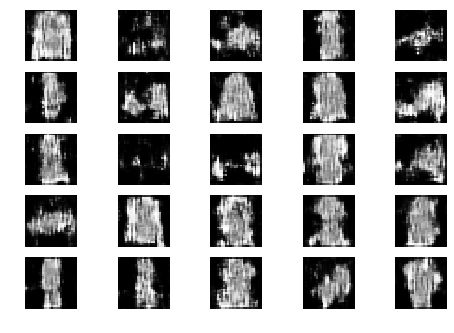

Epoch 1 Batch 101/468 [D loss: 0.404668, acc.: 84.38%] [G loss: 1.734273]
Epoch 1 Batch 102/468 [D loss: 0.481772, acc.: 71.88%] [G loss: 1.363208]
Epoch 1 Batch 103/468 [D loss: 0.448182, acc.: 81.25%] [G loss: 1.551275]
Epoch 1 Batch 104/468 [D loss: 0.644320, acc.: 62.50%] [G loss: 1.822617]
Epoch 1 Batch 105/468 [D loss: 0.626324, acc.: 68.75%] [G loss: 1.543248]
Epoch 1 Batch 106/468 [D loss: 0.461712, acc.: 68.75%] [G loss: 1.842996]
Epoch 1 Batch 107/468 [D loss: 0.580443, acc.: 65.62%] [G loss: 1.862747]
Epoch 1 Batch 108/468 [D loss: 0.539081, acc.: 75.00%] [G loss: 1.539978]
Epoch 1 Batch 109/468 [D loss: 0.866825, acc.: 50.00%] [G loss: 1.059706]
Epoch 1 Batch 110/468 [D loss: 0.333506, acc.: 87.50%] [G loss: 1.517685]
Epoch 1 Batch 111/468 [D loss: 0.381865, acc.: 93.75%] [G loss: 1.587070]
Epoch 1 Batch 112/468 [D loss: 0.338892, acc.: 90.62%] [G loss: 2.002341]
Epoch 1 Batch 113/468 [D loss: 0.651923, acc.: 59.38%] [G loss: 1.849745]
Epoch 1 Batch 114/468 [D loss: 0.64317

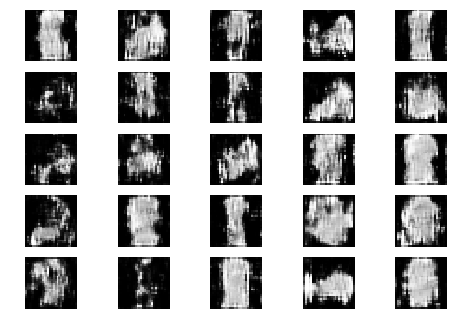

Epoch 1 Batch 151/468 [D loss: 0.501998, acc.: 68.75%] [G loss: 1.421823]
Epoch 1 Batch 152/468 [D loss: 0.678358, acc.: 68.75%] [G loss: 1.374860]
Epoch 1 Batch 153/468 [D loss: 0.487599, acc.: 71.88%] [G loss: 1.394630]
Epoch 1 Batch 154/468 [D loss: 0.464864, acc.: 75.00%] [G loss: 1.619629]
Epoch 1 Batch 155/468 [D loss: 0.396081, acc.: 81.25%] [G loss: 1.826819]
Epoch 1 Batch 156/468 [D loss: 0.673661, acc.: 56.25%] [G loss: 1.361335]
Epoch 1 Batch 157/468 [D loss: 0.516803, acc.: 71.88%] [G loss: 1.538753]
Epoch 1 Batch 158/468 [D loss: 0.429501, acc.: 87.50%] [G loss: 1.714624]
Epoch 1 Batch 159/468 [D loss: 0.329306, acc.: 81.25%] [G loss: 1.706424]
Epoch 1 Batch 160/468 [D loss: 0.590457, acc.: 68.75%] [G loss: 1.887355]
Epoch 1 Batch 161/468 [D loss: 0.430600, acc.: 75.00%] [G loss: 1.626220]
Epoch 1 Batch 162/468 [D loss: 0.365347, acc.: 84.38%] [G loss: 2.077762]
Epoch 1 Batch 163/468 [D loss: 0.509328, acc.: 71.88%] [G loss: 1.559733]
Epoch 1 Batch 164/468 [D loss: 0.49548

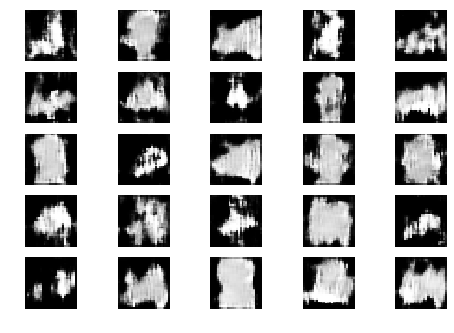

Epoch 1 Batch 201/468 [D loss: 0.389003, acc.: 81.25%] [G loss: 2.420773]
Epoch 1 Batch 202/468 [D loss: 0.408524, acc.: 75.00%] [G loss: 2.267543]
Epoch 1 Batch 203/468 [D loss: 0.616586, acc.: 68.75%] [G loss: 2.006787]
Epoch 1 Batch 204/468 [D loss: 0.683410, acc.: 62.50%] [G loss: 2.022856]
Epoch 1 Batch 205/468 [D loss: 0.571423, acc.: 75.00%] [G loss: 1.841542]
Epoch 1 Batch 206/468 [D loss: 0.342921, acc.: 93.75%] [G loss: 1.559637]
Epoch 1 Batch 207/468 [D loss: 0.707674, acc.: 62.50%] [G loss: 1.681381]
Epoch 1 Batch 208/468 [D loss: 0.531546, acc.: 65.62%] [G loss: 2.115778]
Epoch 1 Batch 209/468 [D loss: 0.200260, acc.: 96.88%] [G loss: 2.340024]
Epoch 1 Batch 210/468 [D loss: 0.396760, acc.: 84.38%] [G loss: 2.098584]
Epoch 1 Batch 211/468 [D loss: 0.351270, acc.: 87.50%] [G loss: 1.668806]
Epoch 1 Batch 212/468 [D loss: 0.622813, acc.: 62.50%] [G loss: 0.948556]
Epoch 1 Batch 213/468 [D loss: 0.496236, acc.: 75.00%] [G loss: 0.986966]
Epoch 1 Batch 214/468 [D loss: 0.95980

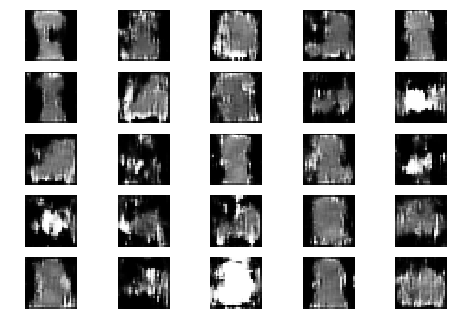

Epoch 1 Batch 251/468 [D loss: 0.426738, acc.: 78.12%] [G loss: 1.623624]
Epoch 1 Batch 252/468 [D loss: 0.381127, acc.: 93.75%] [G loss: 2.115437]
Epoch 1 Batch 253/468 [D loss: 0.672869, acc.: 65.62%] [G loss: 1.915442]
Epoch 1 Batch 254/468 [D loss: 0.362562, acc.: 87.50%] [G loss: 1.723030]
Epoch 1 Batch 255/468 [D loss: 0.432869, acc.: 78.12%] [G loss: 2.115248]
Epoch 1 Batch 256/468 [D loss: 0.489594, acc.: 75.00%] [G loss: 1.101273]
Epoch 1 Batch 257/468 [D loss: 0.846762, acc.: 53.12%] [G loss: 1.383606]
Epoch 1 Batch 258/468 [D loss: 0.274381, acc.: 90.62%] [G loss: 1.740474]
Epoch 1 Batch 259/468 [D loss: 0.526994, acc.: 62.50%] [G loss: 2.224031]
Epoch 1 Batch 260/468 [D loss: 0.615156, acc.: 65.62%] [G loss: 2.276776]
Epoch 1 Batch 261/468 [D loss: 0.331851, acc.: 87.50%] [G loss: 2.182946]
Epoch 1 Batch 262/468 [D loss: 0.315196, acc.: 93.75%] [G loss: 1.845509]
Epoch 1 Batch 263/468 [D loss: 0.349483, acc.: 87.50%] [G loss: 1.832450]
Epoch 1 Batch 264/468 [D loss: 0.35197

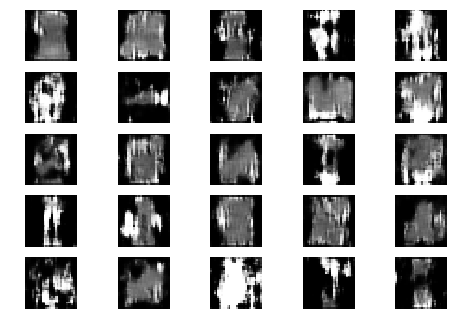

Epoch 1 Batch 301/468 [D loss: 0.398307, acc.: 87.50%] [G loss: 1.831848]
Epoch 1 Batch 302/468 [D loss: 0.651149, acc.: 62.50%] [G loss: 1.884120]
Epoch 1 Batch 303/468 [D loss: 0.652467, acc.: 56.25%] [G loss: 1.554052]
Epoch 1 Batch 304/468 [D loss: 0.389454, acc.: 87.50%] [G loss: 1.533100]
Epoch 1 Batch 305/468 [D loss: 0.668047, acc.: 68.75%] [G loss: 1.162241]
Epoch 1 Batch 306/468 [D loss: 0.375000, acc.: 84.38%] [G loss: 1.550625]
Epoch 1 Batch 307/468 [D loss: 0.527215, acc.: 81.25%] [G loss: 1.598448]
Epoch 1 Batch 308/468 [D loss: 0.511055, acc.: 71.88%] [G loss: 1.645041]
Epoch 1 Batch 309/468 [D loss: 0.622756, acc.: 62.50%] [G loss: 1.370223]
Epoch 1 Batch 310/468 [D loss: 0.477893, acc.: 78.12%] [G loss: 1.363476]
Epoch 1 Batch 311/468 [D loss: 0.708013, acc.: 71.88%] [G loss: 1.975957]
Epoch 1 Batch 312/468 [D loss: 0.374587, acc.: 84.38%] [G loss: 2.719053]
Epoch 1 Batch 313/468 [D loss: 0.517066, acc.: 68.75%] [G loss: 2.423720]
Epoch 1 Batch 314/468 [D loss: 0.46324

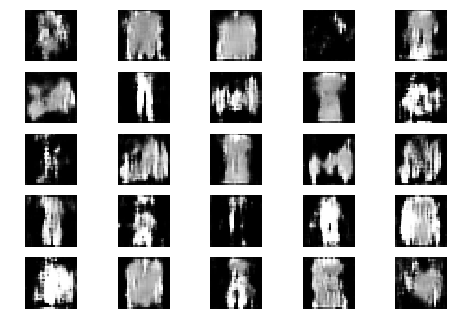

Epoch 1 Batch 351/468 [D loss: 0.513921, acc.: 68.75%] [G loss: 1.591462]
Epoch 1 Batch 352/468 [D loss: 0.663799, acc.: 65.62%] [G loss: 1.279783]
Epoch 1 Batch 353/468 [D loss: 0.563430, acc.: 59.38%] [G loss: 1.439426]
Epoch 1 Batch 354/468 [D loss: 0.641355, acc.: 65.62%] [G loss: 1.182382]
Epoch 1 Batch 355/468 [D loss: 0.423560, acc.: 84.38%] [G loss: 1.434579]
Epoch 1 Batch 356/468 [D loss: 0.643284, acc.: 68.75%] [G loss: 2.099564]
Epoch 1 Batch 357/468 [D loss: 0.469440, acc.: 81.25%] [G loss: 1.919213]
Epoch 1 Batch 358/468 [D loss: 0.421301, acc.: 87.50%] [G loss: 2.014413]
Epoch 1 Batch 359/468 [D loss: 0.520783, acc.: 71.88%] [G loss: 1.418782]
Epoch 1 Batch 360/468 [D loss: 0.425957, acc.: 78.12%] [G loss: 1.613289]
Epoch 1 Batch 361/468 [D loss: 0.243856, acc.: 87.50%] [G loss: 1.577442]
Epoch 1 Batch 362/468 [D loss: 0.894492, acc.: 46.88%] [G loss: 1.300460]
Epoch 1 Batch 363/468 [D loss: 0.316927, acc.: 90.62%] [G loss: 1.862607]
Epoch 1 Batch 364/468 [D loss: 0.27818

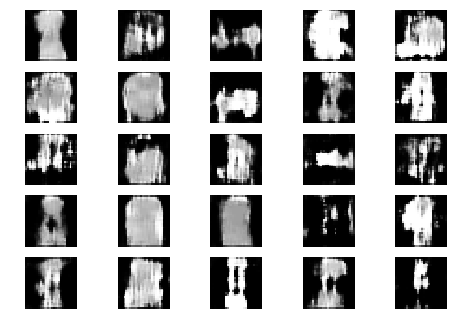

Epoch 1 Batch 401/468 [D loss: 0.641778, acc.: 68.75%] [G loss: 2.124797]
Epoch 1 Batch 402/468 [D loss: 0.476720, acc.: 84.38%] [G loss: 2.307758]
Epoch 1 Batch 403/468 [D loss: 0.477418, acc.: 78.12%] [G loss: 1.273029]
Epoch 1 Batch 404/468 [D loss: 0.576437, acc.: 71.88%] [G loss: 1.621088]
Epoch 1 Batch 405/468 [D loss: 0.569747, acc.: 68.75%] [G loss: 1.384021]
Epoch 1 Batch 406/468 [D loss: 0.549108, acc.: 62.50%] [G loss: 1.377548]
Epoch 1 Batch 407/468 [D loss: 0.478579, acc.: 81.25%] [G loss: 1.753751]
Epoch 1 Batch 408/468 [D loss: 0.479828, acc.: 81.25%] [G loss: 2.054906]
Epoch 1 Batch 409/468 [D loss: 0.596120, acc.: 71.88%] [G loss: 1.408133]
Epoch 1 Batch 410/468 [D loss: 0.967479, acc.: 46.88%] [G loss: 1.328811]
Epoch 1 Batch 411/468 [D loss: 0.457351, acc.: 71.88%] [G loss: 1.439574]
Epoch 1 Batch 412/468 [D loss: 0.414130, acc.: 78.12%] [G loss: 1.984711]
Epoch 1 Batch 413/468 [D loss: 0.548518, acc.: 68.75%] [G loss: 1.809905]
Epoch 1 Batch 414/468 [D loss: 0.34354

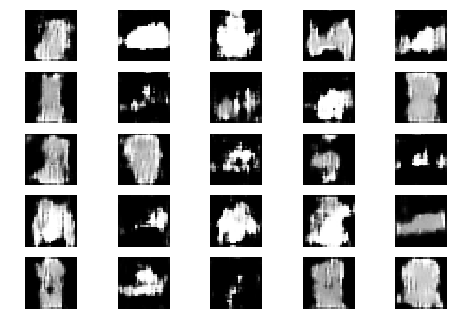

Epoch 1 Batch 451/468 [D loss: 0.549703, acc.: 71.88%] [G loss: 2.259166]
Epoch 1 Batch 452/468 [D loss: 0.446445, acc.: 75.00%] [G loss: 2.027351]
Epoch 1 Batch 453/468 [D loss: 0.706683, acc.: 68.75%] [G loss: 2.227481]
Epoch 1 Batch 454/468 [D loss: 0.489767, acc.: 81.25%] [G loss: 2.097537]
Epoch 1 Batch 455/468 [D loss: 0.383006, acc.: 84.38%] [G loss: 1.878425]
Epoch 1 Batch 456/468 [D loss: 0.770751, acc.: 43.75%] [G loss: 1.815975]
Epoch 1 Batch 457/468 [D loss: 0.394616, acc.: 84.38%] [G loss: 1.795316]
Epoch 1 Batch 458/468 [D loss: 0.791387, acc.: 56.25%] [G loss: 1.283893]
Epoch 1 Batch 459/468 [D loss: 0.515756, acc.: 78.12%] [G loss: 1.913881]
Epoch 1 Batch 460/468 [D loss: 0.542216, acc.: 75.00%] [G loss: 1.736858]
Epoch 1 Batch 461/468 [D loss: 0.326292, acc.: 84.38%] [G loss: 1.221404]
Epoch 1 Batch 462/468 [D loss: 0.755707, acc.: 59.38%] [G loss: 1.435753]
Epoch 1 Batch 463/468 [D loss: 0.610917, acc.: 65.62%] [G loss: 2.162771]
Epoch 1 Batch 464/468 [D loss: 0.50550

In [15]:
if __name__ == '__main__':
    main()

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [19]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Number of examples:  15000.0
Number of Batches:  468
Number of epochs:  1
Epoch 0 Batch 0/468 [D loss: 0.498950, acc.: 78.12%] [G loss: 1.210734]


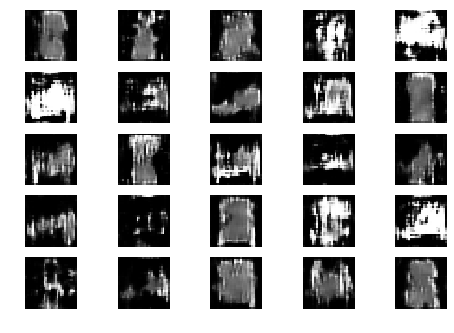

Epoch 0 Batch 1/468 [D loss: 0.532663, acc.: 81.25%] [G loss: 0.772576]
Epoch 0 Batch 2/468 [D loss: 0.484797, acc.: 78.12%] [G loss: 0.209555]
Epoch 0 Batch 3/468 [D loss: 0.419250, acc.: 81.25%] [G loss: 0.105539]
Epoch 0 Batch 4/468 [D loss: 0.443455, acc.: 78.12%] [G loss: 0.035812]
Epoch 0 Batch 5/468 [D loss: 0.228729, acc.: 93.75%] [G loss: 0.035904]
Epoch 0 Batch 6/468 [D loss: 0.539714, acc.: 75.00%] [G loss: 0.040487]
Epoch 0 Batch 7/468 [D loss: 0.349933, acc.: 84.38%] [G loss: 0.010188]
Epoch 0 Batch 8/468 [D loss: 0.145693, acc.: 100.00%] [G loss: 0.015748]
Epoch 0 Batch 9/468 [D loss: 0.184208, acc.: 93.75%] [G loss: 0.008024]
Epoch 0 Batch 10/468 [D loss: 0.182682, acc.: 96.88%] [G loss: 0.007620]
Epoch 0 Batch 11/468 [D loss: 0.461813, acc.: 81.25%] [G loss: 0.007483]
Epoch 0 Batch 12/468 [D loss: 0.151581, acc.: 96.88%] [G loss: 0.008294]
Epoch 0 Batch 13/468 [D loss: 0.311332, acc.: 90.62%] [G loss: 0.008880]
Epoch 0 Batch 14/468 [D loss: 0.240806, acc.: 90.62%] [G lo

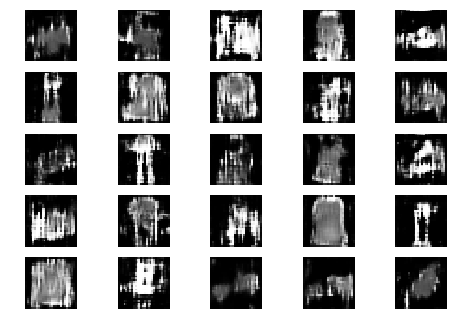

Epoch 0 Batch 51/468 [D loss: 0.040321, acc.: 100.00%] [G loss: 0.000789]
Epoch 0 Batch 52/468 [D loss: 0.107421, acc.: 100.00%] [G loss: 0.001768]
Epoch 0 Batch 53/468 [D loss: 0.126767, acc.: 93.75%] [G loss: 0.000817]
Epoch 0 Batch 54/468 [D loss: 0.172748, acc.: 96.88%] [G loss: 0.002082]
Epoch 0 Batch 55/468 [D loss: 0.124961, acc.: 93.75%] [G loss: 0.001370]
Epoch 0 Batch 56/468 [D loss: 0.143333, acc.: 96.88%] [G loss: 0.001073]
Epoch 0 Batch 57/468 [D loss: 0.115965, acc.: 96.88%] [G loss: 0.001059]
Epoch 0 Batch 58/468 [D loss: 0.106155, acc.: 100.00%] [G loss: 0.001072]
Epoch 0 Batch 59/468 [D loss: 0.132943, acc.: 93.75%] [G loss: 0.001164]
Epoch 0 Batch 60/468 [D loss: 0.012903, acc.: 100.00%] [G loss: 0.000882]
Epoch 0 Batch 61/468 [D loss: 0.140913, acc.: 93.75%] [G loss: 0.000998]
Epoch 0 Batch 62/468 [D loss: 0.148295, acc.: 96.88%] [G loss: 0.000946]
Epoch 0 Batch 63/468 [D loss: 0.201649, acc.: 93.75%] [G loss: 0.000632]
Epoch 0 Batch 64/468 [D loss: 0.046288, acc.: 1

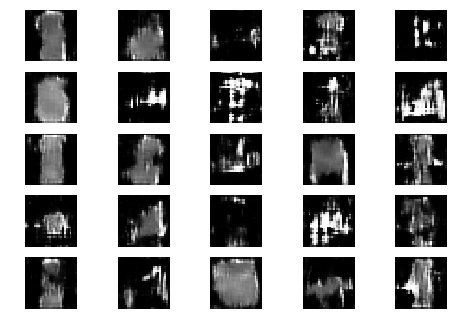

Epoch 0 Batch 101/468 [D loss: 0.150569, acc.: 93.75%] [G loss: 0.000536]
Epoch 0 Batch 102/468 [D loss: 0.380121, acc.: 81.25%] [G loss: 0.000323]
Epoch 0 Batch 103/468 [D loss: 0.018665, acc.: 100.00%] [G loss: 0.000459]
Epoch 0 Batch 104/468 [D loss: 0.100720, acc.: 96.88%] [G loss: 0.000403]
Epoch 0 Batch 105/468 [D loss: 0.024538, acc.: 100.00%] [G loss: 0.000340]
Epoch 0 Batch 106/468 [D loss: 0.186018, acc.: 90.62%] [G loss: 0.000197]
Epoch 0 Batch 107/468 [D loss: 0.083934, acc.: 100.00%] [G loss: 0.000531]
Epoch 0 Batch 108/468 [D loss: 0.008597, acc.: 100.00%] [G loss: 0.000350]
Epoch 0 Batch 109/468 [D loss: 0.238279, acc.: 96.88%] [G loss: 0.000343]
Epoch 0 Batch 110/468 [D loss: 0.053357, acc.: 100.00%] [G loss: 0.000355]
Epoch 0 Batch 111/468 [D loss: 0.022059, acc.: 100.00%] [G loss: 0.000396]
Epoch 0 Batch 112/468 [D loss: 0.021094, acc.: 100.00%] [G loss: 0.000494]
Epoch 0 Batch 113/468 [D loss: 0.063188, acc.: 100.00%] [G loss: 0.000334]
Epoch 0 Batch 114/468 [D loss:

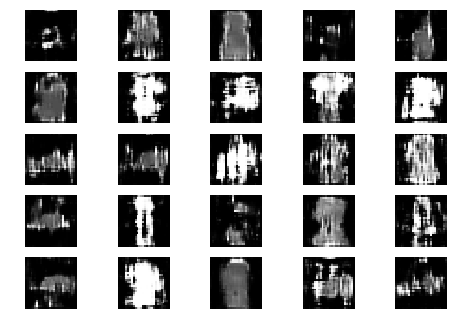

Epoch 0 Batch 151/468 [D loss: 0.343935, acc.: 84.38%] [G loss: 0.000384]
Epoch 0 Batch 152/468 [D loss: 0.035547, acc.: 100.00%] [G loss: 0.000147]
Epoch 0 Batch 153/468 [D loss: 0.060022, acc.: 100.00%] [G loss: 0.000217]
Epoch 0 Batch 154/468 [D loss: 0.557608, acc.: 78.12%] [G loss: 0.000184]
Epoch 0 Batch 155/468 [D loss: 0.070378, acc.: 96.88%] [G loss: 0.000322]
Epoch 0 Batch 156/468 [D loss: 0.012758, acc.: 100.00%] [G loss: 0.000348]
Epoch 0 Batch 157/468 [D loss: 0.012906, acc.: 100.00%] [G loss: 0.000312]
Epoch 0 Batch 158/468 [D loss: 0.015689, acc.: 100.00%] [G loss: 0.000153]
Epoch 0 Batch 159/468 [D loss: 0.020052, acc.: 100.00%] [G loss: 0.000249]
Epoch 0 Batch 160/468 [D loss: 0.054161, acc.: 100.00%] [G loss: 0.000277]
Epoch 0 Batch 161/468 [D loss: 0.015720, acc.: 100.00%] [G loss: 0.000315]
Epoch 0 Batch 162/468 [D loss: 0.046577, acc.: 100.00%] [G loss: 0.000238]
Epoch 0 Batch 163/468 [D loss: 0.070575, acc.: 100.00%] [G loss: 0.000168]
Epoch 0 Batch 164/468 [D los

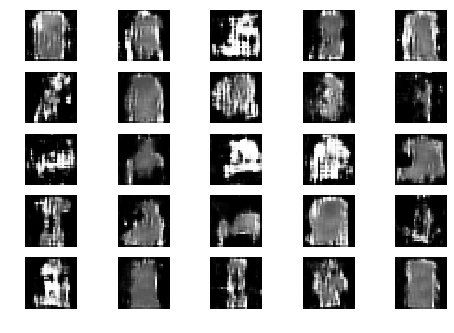

Epoch 0 Batch 201/468 [D loss: 0.112553, acc.: 96.88%] [G loss: 0.000176]
Epoch 0 Batch 202/468 [D loss: 0.039119, acc.: 100.00%] [G loss: 0.000116]
Epoch 0 Batch 203/468 [D loss: 0.111985, acc.: 100.00%] [G loss: 0.000245]
Epoch 0 Batch 204/468 [D loss: 0.005452, acc.: 100.00%] [G loss: 0.000157]
Epoch 0 Batch 205/468 [D loss: 0.026383, acc.: 100.00%] [G loss: 0.000155]
Epoch 0 Batch 206/468 [D loss: 0.010654, acc.: 100.00%] [G loss: 0.000090]
Epoch 0 Batch 207/468 [D loss: 0.028037, acc.: 100.00%] [G loss: 0.000095]
Epoch 0 Batch 208/468 [D loss: 0.052350, acc.: 100.00%] [G loss: 0.000131]
Epoch 0 Batch 209/468 [D loss: 0.014161, acc.: 100.00%] [G loss: 0.000114]
Epoch 0 Batch 210/468 [D loss: 0.048796, acc.: 100.00%] [G loss: 0.000177]
Epoch 0 Batch 211/468 [D loss: 0.078246, acc.: 100.00%] [G loss: 0.000228]
Epoch 0 Batch 212/468 [D loss: 0.069572, acc.: 96.88%] [G loss: 0.000157]
Epoch 0 Batch 213/468 [D loss: 0.048987, acc.: 100.00%] [G loss: 0.000139]
Epoch 0 Batch 214/468 [D lo

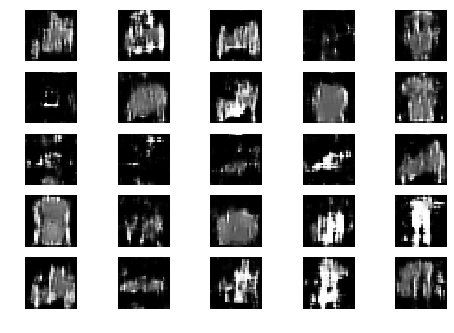

Epoch 0 Batch 251/468 [D loss: 0.011035, acc.: 100.00%] [G loss: 0.000126]
Epoch 0 Batch 252/468 [D loss: 0.024977, acc.: 100.00%] [G loss: 0.000072]
Epoch 0 Batch 253/468 [D loss: 0.066904, acc.: 100.00%] [G loss: 0.000087]
Epoch 0 Batch 254/468 [D loss: 0.107581, acc.: 96.88%] [G loss: 0.000071]
Epoch 0 Batch 255/468 [D loss: 0.009778, acc.: 100.00%] [G loss: 0.000136]
Epoch 0 Batch 256/468 [D loss: 0.040345, acc.: 100.00%] [G loss: 0.000064]
Epoch 0 Batch 257/468 [D loss: 1.688855, acc.: 21.88%] [G loss: 0.000070]
Epoch 0 Batch 258/468 [D loss: 0.266850, acc.: 87.50%] [G loss: 0.000066]
Epoch 0 Batch 259/468 [D loss: 0.040797, acc.: 100.00%] [G loss: 0.000115]
Epoch 0 Batch 260/468 [D loss: 0.023780, acc.: 100.00%] [G loss: 0.000161]
Epoch 0 Batch 261/468 [D loss: 0.008630, acc.: 100.00%] [G loss: 0.000091]
Epoch 0 Batch 262/468 [D loss: 0.014734, acc.: 100.00%] [G loss: 0.000202]
Epoch 0 Batch 263/468 [D loss: 0.044725, acc.: 100.00%] [G loss: 0.000129]
Epoch 0 Batch 264/468 [D los

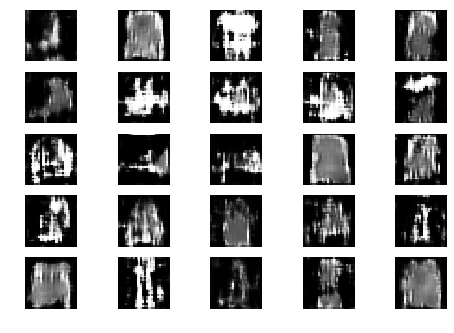

Epoch 0 Batch 301/468 [D loss: 0.010600, acc.: 100.00%] [G loss: 0.000085]
Epoch 0 Batch 302/468 [D loss: 0.005516, acc.: 100.00%] [G loss: 0.000057]
Epoch 0 Batch 303/468 [D loss: 0.011997, acc.: 100.00%] [G loss: 0.000036]
Epoch 0 Batch 304/468 [D loss: 0.115441, acc.: 93.75%] [G loss: 0.000056]
Epoch 0 Batch 305/468 [D loss: 0.267383, acc.: 90.62%] [G loss: 0.000066]
Epoch 0 Batch 306/468 [D loss: 0.036466, acc.: 100.00%] [G loss: 0.000123]
Epoch 0 Batch 307/468 [D loss: 0.165819, acc.: 90.62%] [G loss: 0.000085]
Epoch 0 Batch 308/468 [D loss: 0.015805, acc.: 100.00%] [G loss: 0.000049]
Epoch 0 Batch 309/468 [D loss: 0.028596, acc.: 100.00%] [G loss: 0.000094]
Epoch 0 Batch 310/468 [D loss: 0.058707, acc.: 100.00%] [G loss: 0.000062]
Epoch 0 Batch 311/468 [D loss: 0.033025, acc.: 100.00%] [G loss: 0.000073]
Epoch 0 Batch 312/468 [D loss: 0.023962, acc.: 100.00%] [G loss: 0.000075]
Epoch 0 Batch 313/468 [D loss: 0.038866, acc.: 96.88%] [G loss: 0.000082]
Epoch 0 Batch 314/468 [D loss

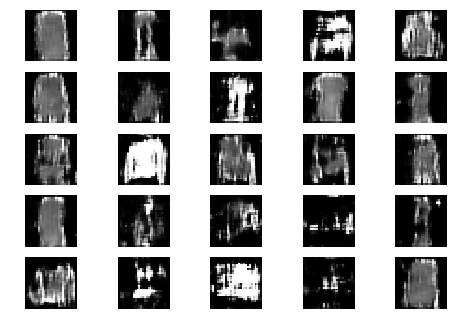

Epoch 0 Batch 351/468 [D loss: 0.001443, acc.: 100.00%] [G loss: 0.000072]
Epoch 0 Batch 352/468 [D loss: 0.001820, acc.: 100.00%] [G loss: 0.000059]
Epoch 0 Batch 353/468 [D loss: 0.012984, acc.: 100.00%] [G loss: 0.000048]
Epoch 0 Batch 354/468 [D loss: 0.010704, acc.: 100.00%] [G loss: 0.000047]
Epoch 0 Batch 355/468 [D loss: 0.047165, acc.: 100.00%] [G loss: 0.000059]
Epoch 0 Batch 356/468 [D loss: 0.055052, acc.: 100.00%] [G loss: 0.000056]
Epoch 0 Batch 357/468 [D loss: 0.041629, acc.: 100.00%] [G loss: 0.000103]
Epoch 0 Batch 358/468 [D loss: 0.011156, acc.: 100.00%] [G loss: 0.000129]
Epoch 0 Batch 359/468 [D loss: 0.028922, acc.: 100.00%] [G loss: 0.000034]
Epoch 0 Batch 360/468 [D loss: 0.004481, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 361/468 [D loss: 0.009325, acc.: 100.00%] [G loss: 0.000113]
Epoch 0 Batch 362/468 [D loss: 0.021702, acc.: 100.00%] [G loss: 0.000055]
Epoch 0 Batch 363/468 [D loss: 0.003247, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 364/468 [D 

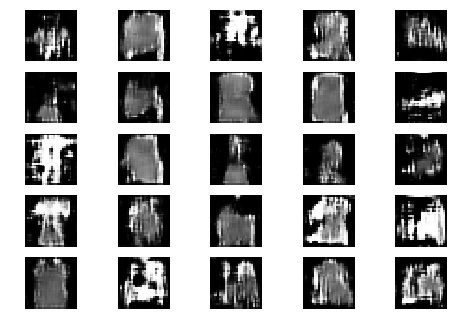

Epoch 0 Batch 401/468 [D loss: 0.007363, acc.: 100.00%] [G loss: 0.000033]
Epoch 0 Batch 402/468 [D loss: 0.006262, acc.: 100.00%] [G loss: 0.000043]
Epoch 0 Batch 403/468 [D loss: 0.062414, acc.: 100.00%] [G loss: 0.000030]
Epoch 0 Batch 404/468 [D loss: 0.051536, acc.: 100.00%] [G loss: 0.000096]
Epoch 0 Batch 405/468 [D loss: 0.008571, acc.: 100.00%] [G loss: 0.000041]
Epoch 0 Batch 406/468 [D loss: 0.009897, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 407/468 [D loss: 0.010971, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 408/468 [D loss: 0.012940, acc.: 100.00%] [G loss: 0.000031]
Epoch 0 Batch 409/468 [D loss: 0.061133, acc.: 100.00%] [G loss: 0.000054]
Epoch 0 Batch 410/468 [D loss: 0.132116, acc.: 96.88%] [G loss: 0.000029]
Epoch 0 Batch 411/468 [D loss: 0.099865, acc.: 96.88%] [G loss: 0.000039]
Epoch 0 Batch 412/468 [D loss: 0.025580, acc.: 96.88%] [G loss: 0.000052]
Epoch 0 Batch 413/468 [D loss: 0.053939, acc.: 100.00%] [G loss: 0.000039]
Epoch 0 Batch 414/468 [D los

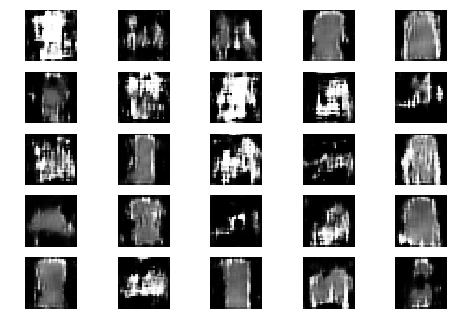

Epoch 0 Batch 451/468 [D loss: 0.000460, acc.: 100.00%] [G loss: 0.000056]
Epoch 0 Batch 452/468 [D loss: 0.031352, acc.: 96.88%] [G loss: 0.000078]
Epoch 0 Batch 453/468 [D loss: 0.006958, acc.: 100.00%] [G loss: 0.000093]
Epoch 0 Batch 454/468 [D loss: 0.003100, acc.: 100.00%] [G loss: 0.000027]
Epoch 0 Batch 455/468 [D loss: 0.037445, acc.: 100.00%] [G loss: 0.000050]
Epoch 0 Batch 456/468 [D loss: 0.029658, acc.: 100.00%] [G loss: 0.000028]
Epoch 0 Batch 457/468 [D loss: 0.056913, acc.: 100.00%] [G loss: 0.000026]
Epoch 0 Batch 458/468 [D loss: 0.002439, acc.: 100.00%] [G loss: 0.000026]
Epoch 0 Batch 459/468 [D loss: 0.028355, acc.: 100.00%] [G loss: 0.000028]
Epoch 0 Batch 460/468 [D loss: 0.001229, acc.: 100.00%] [G loss: 0.000031]
Epoch 0 Batch 461/468 [D loss: 0.429499, acc.: 81.25%] [G loss: 0.000093]
Epoch 0 Batch 462/468 [D loss: 0.017319, acc.: 100.00%] [G loss: 0.000039]
Epoch 0 Batch 463/468 [D loss: 0.030556, acc.: 100.00%] [G loss: 0.000044]
Epoch 0 Batch 464/468 [D lo

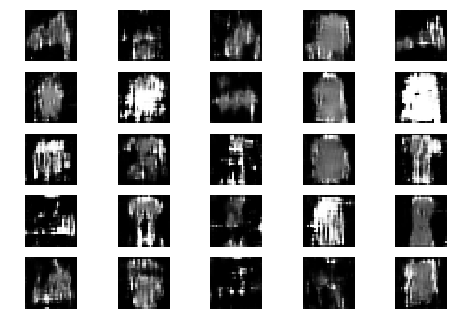

Epoch 1 Batch 1/468 [D loss: 0.003825, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 2/468 [D loss: 0.003518, acc.: 100.00%] [G loss: 0.000077]
Epoch 1 Batch 3/468 [D loss: 0.002344, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 4/468 [D loss: 0.024975, acc.: 100.00%] [G loss: 0.000043]
Epoch 1 Batch 5/468 [D loss: 0.010586, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 6/468 [D loss: 0.044299, acc.: 96.88%] [G loss: 0.000051]
Epoch 1 Batch 7/468 [D loss: 0.006068, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 8/468 [D loss: 0.004988, acc.: 100.00%] [G loss: 0.000050]
Epoch 1 Batch 9/468 [D loss: 0.039737, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 10/468 [D loss: 0.062829, acc.: 96.88%] [G loss: 0.000045]
Epoch 1 Batch 11/468 [D loss: 0.001271, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 12/468 [D loss: 0.032520, acc.: 100.00%] [G loss: 0.000038]
Epoch 1 Batch 13/468 [D loss: 0.188582, acc.: 90.62%] [G loss: 0.000032]
Epoch 1 Batch 14/468 [D loss: 0.030545, acc.: 100.

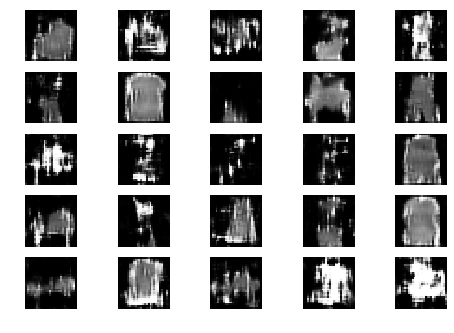

Epoch 1 Batch 51/468 [D loss: 0.001133, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 52/468 [D loss: 0.001301, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 53/468 [D loss: 0.020552, acc.: 100.00%] [G loss: 0.000024]
Epoch 1 Batch 54/468 [D loss: 0.031614, acc.: 100.00%] [G loss: 0.000035]
Epoch 1 Batch 55/468 [D loss: 0.015549, acc.: 100.00%] [G loss: 0.000035]
Epoch 1 Batch 56/468 [D loss: 0.001019, acc.: 100.00%] [G loss: 0.000042]
Epoch 1 Batch 57/468 [D loss: 0.002283, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 58/468 [D loss: 0.003241, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 59/468 [D loss: 0.007023, acc.: 100.00%] [G loss: 0.000039]
Epoch 1 Batch 60/468 [D loss: 0.009248, acc.: 100.00%] [G loss: 0.000031]
Epoch 1 Batch 61/468 [D loss: 0.002460, acc.: 100.00%] [G loss: 0.000053]
Epoch 1 Batch 62/468 [D loss: 0.172233, acc.: 90.62%] [G loss: 0.000023]
Epoch 1 Batch 63/468 [D loss: 0.034922, acc.: 100.00%] [G loss: 0.000039]
Epoch 1 Batch 64/468 [D loss: 0.083974,

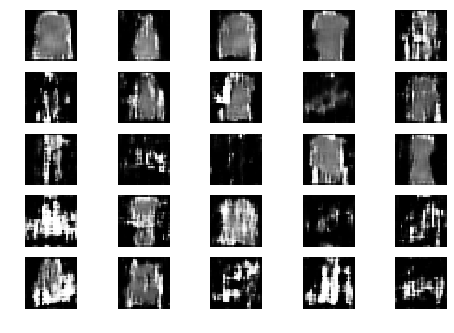

Epoch 1 Batch 101/468 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 102/468 [D loss: 0.000329, acc.: 100.00%] [G loss: 0.000023]
Epoch 1 Batch 103/468 [D loss: 0.005431, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 104/468 [D loss: 0.015169, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 105/468 [D loss: 0.034459, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 106/468 [D loss: 0.004011, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 107/468 [D loss: 0.417881, acc.: 84.38%] [G loss: 0.000016]
Epoch 1 Batch 108/468 [D loss: 0.016832, acc.: 100.00%] [G loss: 0.000049]
Epoch 1 Batch 109/468 [D loss: 0.078785, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 110/468 [D loss: 0.020315, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 111/468 [D loss: 0.016448, acc.: 100.00%] [G loss: 0.000046]
Epoch 1 Batch 112/468 [D loss: 0.067765, acc.: 96.88%] [G loss: 0.000020]
Epoch 1 Batch 113/468 [D loss: 0.709533, acc.: 71.88%] [G loss: 0.000021]
Epoch 1 Batch 114/468 [D los

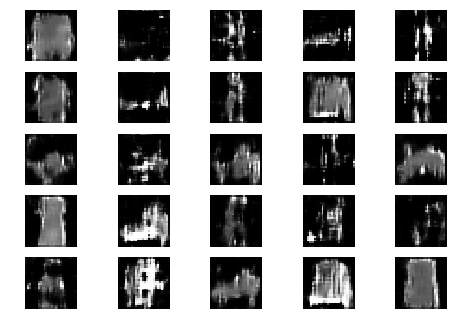

Epoch 1 Batch 151/468 [D loss: 0.011429, acc.: 100.00%] [G loss: 0.000027]
Epoch 1 Batch 152/468 [D loss: 0.031049, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 153/468 [D loss: 0.000218, acc.: 100.00%] [G loss: 0.000050]
Epoch 1 Batch 154/468 [D loss: 0.005291, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 155/468 [D loss: 0.000995, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 156/468 [D loss: 0.002574, acc.: 100.00%] [G loss: 0.000024]
Epoch 1 Batch 157/468 [D loss: 0.067655, acc.: 96.88%] [G loss: 0.000016]
Epoch 1 Batch 158/468 [D loss: 0.002746, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 159/468 [D loss: 0.010570, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 160/468 [D loss: 0.001618, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 161/468 [D loss: 0.024464, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 162/468 [D loss: 0.037238, acc.: 96.88%] [G loss: 0.000021]
Epoch 1 Batch 163/468 [D loss: 0.271228, acc.: 90.62%] [G loss: 0.000016]
Epoch 1 Batch 164/468 [D los

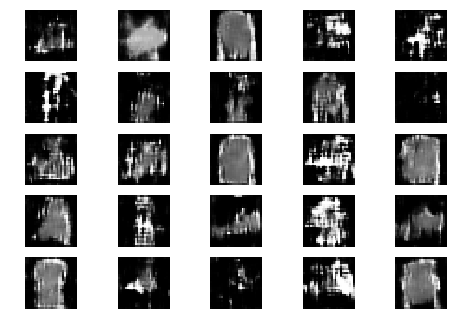

Epoch 1 Batch 201/468 [D loss: 0.009187, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 202/468 [D loss: 0.234691, acc.: 90.62%] [G loss: 0.000021]
Epoch 1 Batch 203/468 [D loss: 0.036422, acc.: 96.88%] [G loss: 0.000010]
Epoch 1 Batch 204/468 [D loss: 0.066663, acc.: 96.88%] [G loss: 0.000013]
Epoch 1 Batch 205/468 [D loss: 0.002337, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 206/468 [D loss: 0.004741, acc.: 100.00%] [G loss: 0.000035]
Epoch 1 Batch 207/468 [D loss: 0.136645, acc.: 90.62%] [G loss: 0.000012]
Epoch 1 Batch 208/468 [D loss: 0.002616, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 209/468 [D loss: 0.003071, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 210/468 [D loss: 0.003368, acc.: 100.00%] [G loss: 0.000029]
Epoch 1 Batch 211/468 [D loss: 0.009545, acc.: 100.00%] [G loss: 0.000030]
Epoch 1 Batch 212/468 [D loss: 0.047817, acc.: 96.88%] [G loss: 0.000015]
Epoch 1 Batch 213/468 [D loss: 0.000718, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 214/468 [D loss:

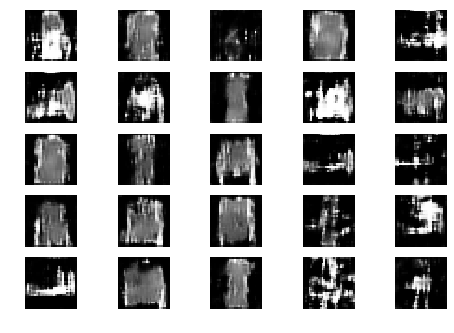

Epoch 1 Batch 251/468 [D loss: 0.018105, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 252/468 [D loss: 0.071826, acc.: 96.88%] [G loss: 0.000015]
Epoch 1 Batch 253/468 [D loss: 0.002570, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 254/468 [D loss: 0.004384, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 255/468 [D loss: 0.008304, acc.: 100.00%] [G loss: 0.000036]
Epoch 1 Batch 256/468 [D loss: 0.001350, acc.: 100.00%] [G loss: 0.000024]
Epoch 1 Batch 257/468 [D loss: 0.012870, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 258/468 [D loss: 0.004863, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 259/468 [D loss: 0.001528, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 260/468 [D loss: 0.015588, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 261/468 [D loss: 0.003706, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 262/468 [D loss: 0.001092, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 263/468 [D loss: 0.000761, acc.: 100.00%] [G loss: 0.000011]
Epoch 1 Batch 264/468 [D l

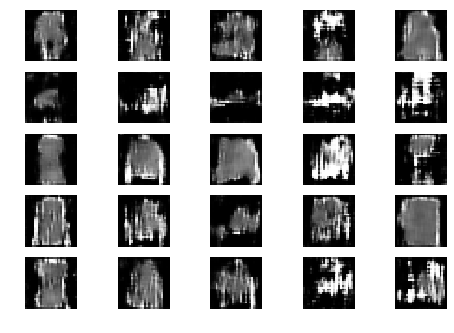

Epoch 1 Batch 301/468 [D loss: 0.000532, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 302/468 [D loss: 0.047617, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 303/468 [D loss: 0.010825, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 304/468 [D loss: 0.043863, acc.: 100.00%] [G loss: 0.000024]
Epoch 1 Batch 305/468 [D loss: 0.038760, acc.: 96.88%] [G loss: 0.000016]
Epoch 1 Batch 306/468 [D loss: 0.093247, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 307/468 [D loss: 0.000285, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 308/468 [D loss: 0.321289, acc.: 84.38%] [G loss: 0.000010]
Epoch 1 Batch 309/468 [D loss: 0.000434, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 310/468 [D loss: 0.083523, acc.: 96.88%] [G loss: 0.000009]
Epoch 1 Batch 311/468 [D loss: 0.015377, acc.: 100.00%] [G loss: 0.000019]
Epoch 1 Batch 312/468 [D loss: 0.129736, acc.: 90.62%] [G loss: 0.000035]
Epoch 1 Batch 313/468 [D loss: 0.002598, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 314/468 [D loss

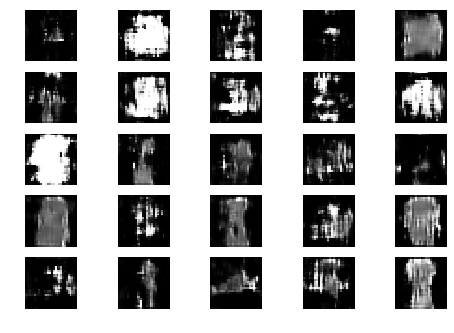

Epoch 1 Batch 351/468 [D loss: 0.019905, acc.: 100.00%] [G loss: 0.000024]
Epoch 1 Batch 352/468 [D loss: 0.030283, acc.: 96.88%] [G loss: 0.000010]
Epoch 1 Batch 353/468 [D loss: 0.018447, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 354/468 [D loss: 0.001869, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 355/468 [D loss: 0.000634, acc.: 100.00%] [G loss: 0.000011]
Epoch 1 Batch 356/468 [D loss: 0.014783, acc.: 100.00%] [G loss: 0.000021]
Epoch 1 Batch 357/468 [D loss: 0.000645, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 358/468 [D loss: 0.004055, acc.: 100.00%] [G loss: 0.000015]
Epoch 1 Batch 359/468 [D loss: 0.002311, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 360/468 [D loss: 0.046040, acc.: 96.88%] [G loss: 0.000015]
Epoch 1 Batch 361/468 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 362/468 [D loss: 0.000454, acc.: 100.00%] [G loss: 0.000020]
Epoch 1 Batch 363/468 [D loss: 0.017006, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 364/468 [D lo

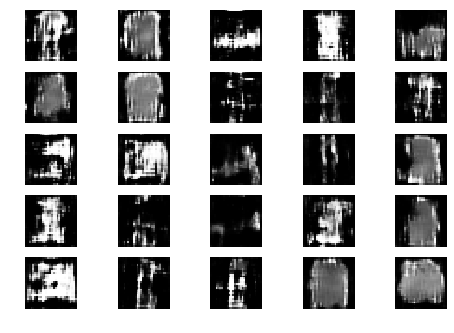

Epoch 1 Batch 401/468 [D loss: 0.001167, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 402/468 [D loss: 0.003079, acc.: 100.00%] [G loss: 0.000018]
Epoch 1 Batch 403/468 [D loss: 0.004982, acc.: 100.00%] [G loss: 0.000009]
Epoch 1 Batch 404/468 [D loss: 0.011541, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 405/468 [D loss: 0.000203, acc.: 100.00%] [G loss: 0.000034]
Epoch 1 Batch 406/468 [D loss: 0.003475, acc.: 100.00%] [G loss: 0.000009]
Epoch 1 Batch 407/468 [D loss: 0.001971, acc.: 100.00%] [G loss: 0.000014]
Epoch 1 Batch 408/468 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.000096]
Epoch 1 Batch 409/468 [D loss: 0.004530, acc.: 100.00%] [G loss: 0.000011]
Epoch 1 Batch 410/468 [D loss: 0.000345, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 411/468 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 412/468 [D loss: 0.032791, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 413/468 [D loss: 0.000255, acc.: 100.00%] [G loss: 0.000022]
Epoch 1 Batch 414/468 [D 

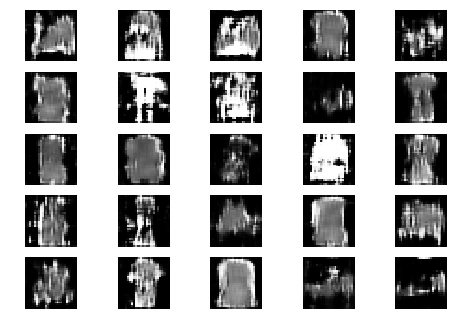

Epoch 1 Batch 451/468 [D loss: 0.000884, acc.: 100.00%] [G loss: 0.000028]
Epoch 1 Batch 452/468 [D loss: 0.008784, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 453/468 [D loss: 0.053242, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 454/468 [D loss: 0.001232, acc.: 100.00%] [G loss: 0.000011]
Epoch 1 Batch 455/468 [D loss: 0.000068, acc.: 100.00%] [G loss: 0.000010]
Epoch 1 Batch 456/468 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 457/468 [D loss: 0.001637, acc.: 100.00%] [G loss: 0.000025]
Epoch 1 Batch 458/468 [D loss: 0.007021, acc.: 100.00%] [G loss: 0.000007]
Epoch 1 Batch 459/468 [D loss: 0.001475, acc.: 100.00%] [G loss: 0.000012]
Epoch 1 Batch 460/468 [D loss: 0.012808, acc.: 100.00%] [G loss: 0.000017]
Epoch 1 Batch 461/468 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.000009]
Epoch 1 Batch 462/468 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.000008]
Epoch 1 Batch 463/468 [D loss: 0.006907, acc.: 100.00%] [G loss: 0.000013]
Epoch 1 Batch 464/468 [D 

In [20]:
train(generator1, discriminator1, combined1,
          epochs=1, batch_size=32, save_interval=1)

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)